In [14]:
import poppy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

In [15]:
%matplotlib inline
matplotlib.rcParams['image.origin'] = 'lower'

In [16]:
D = 2.
wavelen = 1e-6
ovsamp = 4

# No FPM (control case)
fftcoron_noFPM_osys = poppy.OpticalSystem(oversample=ovsamp)
fftcoron_noFPM_osys.addPupil( poppy.CircularAperture(radius=D/2) )
fftcoron_noFPM_osys.addImage()
fftcoron_noFPM_osys.addPupil( poppy.CircularAperture(radius=0.9*D/2) )
fftcoron_noFPM_osys.addDetector( pixelscale=0.025, fov_arcsec=4. )

# Classical Lyot FPM, spot radius ~ 4 lam/D
fftcoron_spotFPM_osys = poppy.OpticalSystem(oversample=ovsamp)
fftcoron_spotFPM_osys.addPupil( poppy.CircularAperture(radius=1.) )
fftcoron_spotFPM_osys.addImage( poppy.CircularOcculter(radius=0.4) ) 
fftcoron_spotFPM_osys.addPupil( poppy.CircularAperture(radius=0.9*D/2) )
fftcoron_spotFPM_osys.addDetector( pixelscale=0.025, fov_arcsec=4. )

# Annular diaphragm FPM, inner radius ~ 4 lam/D, outer rad ~ 16 lam/D
fftcoron_annFPM_osys = poppy.OpticalSystem(oversample=ovsamp)
fftcoron_annFPM_osys.addPupil( poppy.CircularAperture(radius=D/2) )
spot = poppy.CircularOcculter( radius=0.4  )
diaphragm = poppy.InverseTransmission( poppy.CircularOcculter( radius=1.6 ) )
annFPM = poppy.CompoundAnalyticOptic( opticslist = [diaphragm, spot] )
fftcoron_annFPM_osys.addImage( annFPM )
fftcoron_annFPM_osys.addPupil( poppy.CircularAperture(radius=0.9*D/2) )
fftcoron_annFPM_osys.addDetector( pixelscale=0.025, fov_arcsec=4. )

# Re-cast as MFT coronagraph with annular diaphragm FPM
matrixFTcoron_annFPM_osys = poppy.MatrixFTCoronagraph( fftcoron_annFPM_osys, occulter_box=diaphragm.uninverted_optic.radius_inner )

In [17]:
noFPM_fft_psf = fftcoron_noFPM_osys.calcPSF(wavelen, display_intermediates=False)

In [18]:
spotFPM_fft_psf = fftcoron_spotFPM_osys.calcPSF(wavelen, display_intermediates=False)

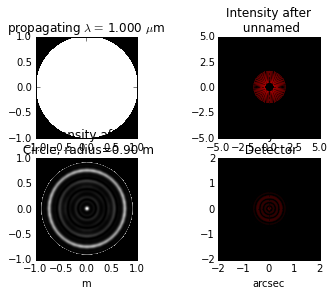

In [19]:
t0_fft = time.time()
annFPM_fft_psf, annFPM_fft_interm = fftcoron_annFPM_osys.calcPSF(wavelen, display_intermediates=True,\
                                                                 return_intermediates=True)
t1_fft = time.time()

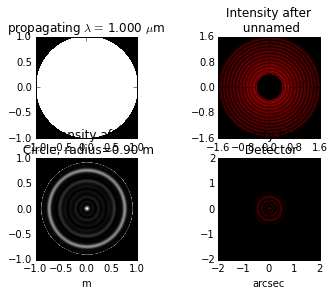

In [20]:
t0_mft = time.time()
annFPM_mft_psf, annFPM_mft_interm = matrixFTcoron_annFPM_osys.calcPSF(wavelen, display_intermediates=True,\
                                                                     return_intermediates=True)
t1_mft = time.time()

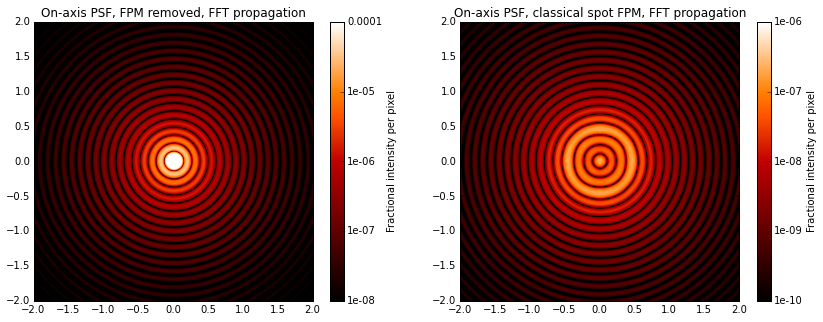

In [21]:
plt.figure(figsize=(14,5))
plt.subplot(121)
poppy.display_PSF(noFPM_fft_psf, vmax=1e-4, title='On-axis PSF, FPM removed, FFT propagation')
plt.subplot(122)
poppy.display_PSF(spotFPM_fft_psf, vmin=1e-10, vmax=1e-6, title='On-axis PSF, classical spot FPM, FFT propagation')

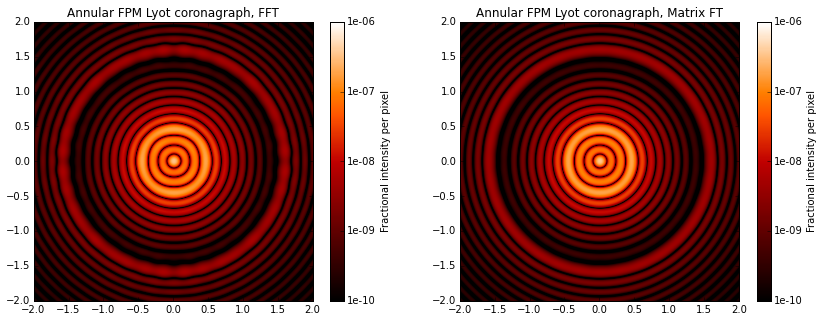

In [22]:
plt.figure(figsize=(14,5))
plt.subplot(121)
poppy.display_PSF(annFPM_fft_psf, vmin=1e-10, vmax=1e-6, title='Annular FPM Lyot coronagraph, FFT')
plt.subplot(122)
poppy.display_PSF(annFPM_mft_psf, vmin=1e-10, vmax=1e-6, title='Annular FPM Lyot coronagraph, Matrix FT')

In [23]:
lamoD_asec = wavelen/fftcoron_annFPM_osys.planes[0].pupil_diam * 180/np.pi * 3600
print "System diffraction resolution element scale (lambda/D) in arcsec: %.3f" % lamoD_asec
print "Array width in first focal plane, FFT: %d" % annFPM_fft_interm[1].amplitude.shape[0]
print "Array width in first focal plane, MatrixFT: %d" % annFPM_mft_interm[1].amplitude.shape[0]
print "Array width in Lyot plane, FFT: %d" % annFPM_fft_interm[2].amplitude.shape[0]
print "Array width in Lyot plane, MatrixFT: %d" % annFPM_mft_interm[2].amplitude.shape[0]

System diffraction resolution element scale (lambda/D) in arcsec: 0.103
Array width in first focal plane, FFT: 4096
Array width in first focal plane, MatrixFT: 248
Array width in Lyot plane, FFT: 4096
Array width in Lyot plane, MatrixFT: 1024


In [24]:
SoS_res = np.sum( (annFPM_mft_psf[0].data - annFPM_fft_psf[0].data)**2 )
print "Sum-of-squares disparity between MatrixFT and FFT PSF intensity arrays: %g" % SoS_res

Sum-of-squares disparity between MatrixFT and FFT PSF intensity arrays: 2.03559e-12


In [25]:
print "Elapsed time, FFT:  %.1f s" % (t1_fft-t0_fft)
print "Elapsed time, Matrix FT:  %.1f s" % (t1_mft-t0_mft)

Elapsed time, FFT:  30.3 s
Elapsed time, Matrix FT:  2.6 s
